In [1]:
from bs4 import BeautifulSoup
import re
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from tqdm import tqdm

In [2]:
def process_string(string):
    string = re.sub('[^A-Za-z0-9\-\/ ]+', ' ', string).split()
    return [y.strip() for y in string]

In [3]:
def parse_raw(filename):
    with open(filename, 'r') as fopen:
        entities = fopen.read()
    soup = BeautifulSoup(entities, 'html.parser')
    inside_tag = ''
    texts, labels = [], []
    for sentence in soup.prettify().split('\n'):
        if len(inside_tag):
            splitted = process_string(sentence)
            texts += splitted
            labels += [inside_tag] * len(splitted)
            inside_tag = ''
        else:
            if not sentence.find('</'):
                pass
            elif not sentence.find('<'):
                inside_tag = sentence.split('>')[0][1:]
            else:
                splitted = process_string(sentence)
                texts += splitted
                labels += ['OTHER'] * len(splitted)
    assert (len(texts)==len(labels)), "length texts and labels are not same"
    print('len texts and labels: ', len(texts))
    return texts,labels

In [4]:
train_texts, train_labels = parse_raw('data_train.txt')
test_texts, test_labels = parse_raw('data_test.txt')
train_texts += test_texts
train_labels += test_labels

len texts and labels:  34012
len texts and labels:  9249


In [5]:
np.unique(train_labels,return_counts=True)

(array(['OTHER', 'location', 'organization', 'person', 'quantity', 'time'],
       dtype='<U12'), array([35613,  1536,  1592,  2358,  1336,   826]))

In [6]:
with open('entities-bm-normalize-v3.txt','r') as fopen:
    entities_bm = fopen.read().split('\n')[:-1]
entities_bm = [i.split() for i in entities_bm]
entities_bm = [[i[0],'TIME' if i[0] in 'jam' else i[1]] for i in entities_bm]

In [7]:
replace_by = {'LOC':'location','PRN':'person','NORP':'organization','ORG':'organization','LAW':'law',
             'EVENT':'OTHER','FAC':'organization','TIME':'time','O':'OTHER','ART':'person','DOC':'law'}
for i in entities_bm:
    try:
        string = process_string(i[0])
        if len(string):
            train_labels.append(replace_by[i[1]])
            train_texts.append(process_string(i[0])[0])  
    except Exception as e:
        print(e)
        
assert (len(train_texts)==len(train_labels)), "length texts and labels are not same"

'KN'
'KA'


In [8]:
np.unique(train_labels,return_counts=True)

(array(['OTHER', 'law', 'location', 'organization', 'person', 'quantity',
        'time'], dtype='<U12'),
 array([47406,   107,  2010,  2435,  3913,  1336,  1240]))

In [9]:
word2idx = {'PAD': 0,'NUM':1,'UNK':2}
tag2idx = {'PAD': 0}
char2idx = {'PAD': 0}
word_idx = 3
tag_idx = 1
char_idx = 1

def parse_XY(texts, labels):
    global word2idx, tag2idx, char2idx, word_idx, tag_idx, char_idx
    X, Y = [], []
    for no, text in enumerate(texts):
        tag = labels[no]
        for c in text:
            if c not in char2idx:
                char2idx[c] = char_idx
                char_idx += 1
        if tag not in tag2idx:
            tag2idx[tag] = tag_idx
            tag_idx += 1
        Y.append(tag2idx[tag])
        text = text.lower()
        if text not in word2idx:
            word2idx[text] = word_idx
            word_idx += 1
        X.append(word2idx[text])
    return X, np.array(Y)

In [10]:
np.unique(train_labels)

array(['OTHER', 'law', 'location', 'organization', 'person', 'quantity',
       'time'], dtype='<U12')

In [11]:
X, Y = parse_XY(train_texts, train_labels)
idx2word={idx: tag for tag, idx in word2idx.items()}
idx2tag = {i: w for w, i in tag2idx.items()}

In [12]:
seq_len = 50
def iter_seq(x):
    return np.array([x[i: i+seq_len] for i in range(0, len(x)-seq_len, 1)])

def to_train_seq(*args):
    return [iter_seq(x) for x in args]

In [13]:
X_seq, Y_seq = to_train_seq(X, Y)
X_seq.shape

(58397, 50)

In [14]:
import json
with open('crf-lstm-bidirectional.json','w') as fopen:
    fopen.write(json.dumps({'idx2tag':idx2tag,'idx2word':idx2word,
           'word2idx':word2idx,'tag2idx':tag2idx}))

In [15]:
from keras.utils import to_categorical
Y_seq_3d = [to_categorical(i, num_classes=len(tag2idx)) for i in Y_seq]

Using TensorFlow backend.


In [16]:
from sklearn.cross_validation import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(X_seq, Y_seq_3d, test_size=0.1)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
import keras
print(keras.__version__)

2.2.2


In [18]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras.backend.tensorflow_backend import set_session
set_session(tf.InteractiveSession())

In [19]:
max_len = seq_len
input_word = Input(shape=(None,))
model = Embedding(input_dim=len(word2idx) + 1, output_dim=128, mask_zero=True)(input_word)
model = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(50, activation="relu"))(model)
crf = CRF(len(tag2idx))
out = crf(model)

In [20]:
model = Model(input_word, out)

In [21]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         1215872   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 50)          6450      
_________________________________________________________________
crf_1 (CRF)                  (None, None, 8)           488       
Total params: 1,321,626
Trainable params: 1,321,626
Non-trainable params: 0
_________________________________________________________________


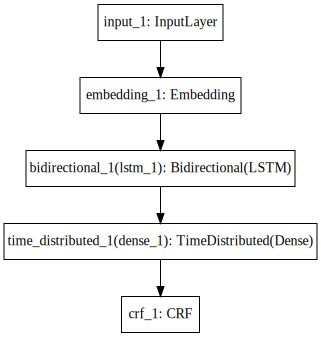

In [23]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [24]:
history = model.fit(train_X, np.array(train_Y), batch_size=32, epochs=2,
                    validation_split=0.1, verbose=1)

Train on 47301 samples, validate on 5256 samples
Epoch 1/2
47301/47301 [==============================] - 305s 6ms/step - loss: 0.1326 - acc: 0.9597 - val_loss: 0.0056 - val_acc: 0.9982
Epoch 2/2
47301/47301 [==============================] - 304s 6ms/step - loss: 0.0041 - acc: 0.9986 - val_loss: 0.0025 - val_acc: 0.9992


In [25]:
predicted=model.predict(test_X,verbose=1)

5840/5840 [==============================] - 12s 2ms/step


In [26]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
    
pred_labels = pred2label(predicted)
test_labels = pred2label(test_Y)

In [27]:
from sklearn.metrics import classification_report
print(classification_report(np.array(test_labels).ravel(), np.array(pred_labels).ravel()))

              precision    recall  f1-score   support

       OTHER       1.00      1.00      1.00    236927
         law       1.00      0.99      1.00       500
    location       1.00      1.00      1.00     10216
organization       1.00      1.00      1.00     11752
      person       1.00      1.00      1.00     19320
    quantity       1.00      1.00      1.00      7097
        time       1.00      0.99      1.00      6188

 avg / total       1.00      1.00      1.00    292000



In [28]:
model.save_weights('crf-lstm-bidirectional.h5')